In [80]:
reframed = pd.read_csv("supervised_1_1.csv")
reframed.drop(['Unnamed: 0'], axis=1, inplace=True)
reframed.head()

In [83]:
# split into train and test sets
# now order needs to be by day rather than by station -- reorder by num_days
# var21(t-1) is num_days
# var18(t-1) is station
n = 7303576
reframed.sort_values(by=['var21(t-1)', 'var18(t-1)'], inplace=True)
values = reframed.values
n_train_days = int(n*.95)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-n_seq], train[:, -n_seq]
test_X, test_y = test[:, :-n_seq], test[:, -n_seq]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6938397, 1, 21) (6938397,) (365179, 1, 21) (365179,)


Train on 6938397 samples, validate on 365179 samples
Epoch 1/10
 - 44s - loss: 0.0265 - val_loss: 0.0179
Epoch 2/10
 - 44s - loss: 0.0163 - val_loss: 0.0172
Epoch 3/10
 - 40s - loss: 0.0144 - val_loss: 0.0149
Epoch 4/10
 - 42s - loss: 0.0140 - val_loss: 0.0117
Epoch 5/10
 - 43s - loss: 0.0125 - val_loss: 0.0102
Epoch 6/10
 - 43s - loss: 0.0123 - val_loss: 0.0174
Epoch 7/10
 - 39s - loss: 0.0126 - val_loss: 0.0127
Epoch 8/10
 - 40s - loss: 0.0105 - val_loss: 0.0114
Epoch 9/10
 - 40s - loss: 0.0107 - val_loss: 0.0145
Epoch 10/10
 - 40s - loss: 0.0101 - val_loss: 0.0102


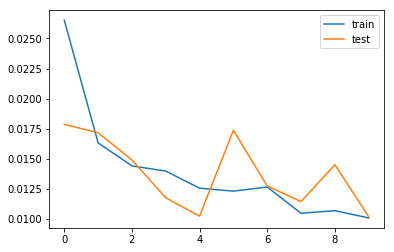

In [84]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_seq))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=7200, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [85]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.056
